## Importing Libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf

from itertools import islice

# Keras
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, MaxPooling1D, Conv1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')
import matplotlib.style as style;

random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

## Loading Dataset and splitting into Train, Validation and Test

In [2]:
vocab_size = 10000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size)

x_train = pad_sequences(x_train, maxlen = maxlen, padding = 'pre')
x_test =  pad_sequences(x_test, maxlen = maxlen, padding = 'pre')

X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = random_state, shuffle = True)

## Shape of features and labels 

In [3]:
print(f'\nShape of training dataset: {x_train.shape}')
print(f'Unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('==='*15)
print(f'\nShape of validation dataset: {x_valid.shape}')
print(f'Unique words in validation dataset: {len(np.unique(np.hstack(x_valid)))}')

print('==='*15)
print(f'\nShape of test dataset: {x_test.shape}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

print('==='*15)
print(f'\nUnique Categories: {np.unique(y_train), np.unique(y_valid), np.unique(y_test)}')


Shape of training dataset: (32000, 300)
Unique words in training dataset: 9999

Shape of validation dataset: (8000, 300)
Unique words in validation dataset: 9984

Shape of test dataset: (10000, 300)
Number of unique words in test dataset: 9995

Unique Categories: (array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64))


## Value of any one feature and its label

In [4]:
print('Data on 1st Index:')
print(x_train[0])
print('==='*20)
print('Label:')
print(y_train[0])

Data on 1st Index:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1    4   64  614   96    8  358   14  509    9    8 4040  129
  419  429    4 1513 1741   49 6177    2    7    4 1224  387    6  762
    7  129 1224 7851  783    5  280   25   26 8394 2985 3000  382   95
   25  238  358   14   22   10   10    4   64 1907 1698   16    4   65
  200    2    5 6958 7767   16  321   11    4  217    7    4 7212 2658
    5   38   16    4 8145  250  382   48   36   62   28 1075    4  226
   20   23   68    2   11 2853    5   89   36  853  809   11  119   62
   28   93   12    6   76   53  737   22   10   10    4   64  282   13
  520   12    6  342  675    9   88    7    2    5   27 12

## Get original sentence by decoding the feature value

In [5]:
def decode_review(x, y):
  w2i = imdb.get_word_index()                                
  w2i = {k:(v + 3) for k, v in w2i.items()}
  w2i['<PAD>'] = 0
  w2i['<START>'] = 1
  w2i['<UNK>'] = 2
  i2w = {i: w for w, i in w2i.items()}

  ws = (' '.join(i2w[i] for i in x))
  print(f'Review: {ws}')
  print(f'===='*15)
  print(f'Actual Sentiment: {y}')
  return w2i, i2w

w2i, i2w = decode_review(x_train[1], y_train[1])

# get first 100 (key, value) pairs from id to word dictionary
print('==='*15)
print(list(islice(i2w.items(), 0, 100)))

Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> rock <UNK> roll high school will probably have to go down in history as the ultimate rebellious party flick portraying a bunch of high school students using the <UNK> music as inspiration to rise up against their <UNK> principal mary <UNK> of eating <UNK> fame the whole movie is a mile a minute it's basically a big excuse to have fun and i'm sure that you will <UNK> <UNK> check a <UNK> music teacher paul <UNK> also from eating <UNK> check exploding mice <UNK> br br anyway this is the sort of stuff that makes life wor

## Design, Train, Test and Tune a sequential model

In [6]:
# Model
model = Sequential()
model.add(Embedding(vocab_size, 256, input_length = maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(Conv1D(128, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(75))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          2560000   
_________________________________________________________________
dropout (Dropout)            (None, 300, 256)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 256)          327936    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 128)          163968    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 64)            0

In [7]:
# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1)  
mc = ModelCheckpoint('imdb_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

In [8]:
# Fit the model
model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs = 2, batch_size = 64, verbose = True, callbacks = [es, mc])

# Evaluate the model
scores = model.evaluate(x_test, y_test, batch_size = 64)
print('Test accuracy: %.2f%%' % (scores[1]*100))

Epoch 1/2
500/500 [==============================] - 305s 606ms/step - loss: 0.4581 - accuracy: 0.7440 - val_loss: 0.2507 - val_accuracy: 0.8965

Epoch 00001: val_loss improved from inf to 0.25066, saving model to imdb_model.h5
Epoch 2/2
500/500 [==============================] - 307s 615ms/step - loss: 0.1708 - accuracy: 0.9361 - val_loss: 0.2574 - val_accuracy: 0.8926

Epoch 00002: val_loss did not improve from 0.25066
Epoch 00002: early stopping
157/157 [==============================] - 21s 132ms/step - loss: 0.2539 - accuracy: 0.8963
Test accuracy: 89.63%


## Classification Report

In [9]:
from sklearn import metrics

y_pred = model.predict_classes(x_test)

print('Classification report: ')
display_label = ["Positive", "Negative"]
print(classification_report(y_test,y_pred, target_names=display_label))

Classification report: 
              precision    recall  f1-score   support

    Positive       0.86      0.94      0.90      4912
    Negative       0.93      0.86      0.89      5088

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Confusion Matrix

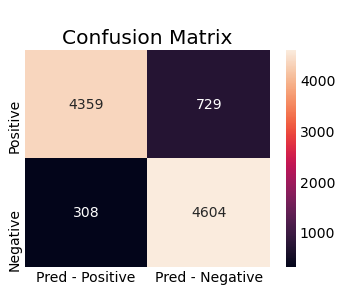

In [10]:
lab = [1,0]
cm = metrics.confusion_matrix(y_test, y_pred, labels=lab)
plab=[f"Pred - {s}" for s in display_label]
df_cm = pd.DataFrame(cm, index = display_label, columns = plab)   
plt.figure(figsize = (5.5,4))
style.use('fivethirtyeight')
sns.heatmap(df_cm, annot=True, fmt='g') 
plt.title(f'\nConfusion Matrix')
plt.show()

## Print the prediction on one sample.


In [11]:
decode_review(x_test[1], y_test[1])
print(f'===='*15)
print(f'Predicted sentiment: {y_pred[1][0]}')

Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> overall this movie is dreadful and should have never been made one of the problems with this movie is that there is no link to the audience and the characters for example if she is about to be attacked you want to feel oh my god no but you don't in this case you don't care because there is no link that has been made to know the character in the trailer it seemed as though the movie would be great yet there is no suspense what so ever really there could have been maybe some mystery but there is not all she has is a <UNK> was said on the dvd's back you would t

## Conclusion
Classification model analysing customer's sentiments has been created with following result summary:<br>
Sequential model with CNN and LSTM.<br>
Accuracy: 89.63%<br>
F1-score: 90%<br>
Loss of 0.26<br>